# Kaggle과 Colab 연동 

In [ ]:
!pip install kaggle 
from google.colab import files 
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


KeyboardInterrupt: ignored

In [ ]:
!mkdir -p ~/.kaggle #create folder name Kaggle
!cp kaggle.json ~/.kaggle #copy kaggle.jason into folder Kaggle
!chmod 600 ~/.kaggle/kaggle.json #ignore Permission Warning 

In [ ]:
#Copy API command 후 데이터셋 다운로드하기  
!kaggle competitions download -c bike-sharing-demand

#파일 압축 풀기
!unzip bike-sharing-demand.zip

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 57.6MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!mkdir -p ~/.kaggle/competitions/bike-sharing-demand #create folder name Kaggle
!cp sampleSubmission.csv ~/.kaggle/competitions/bike-sharing-demand #copy into folder Kaggle
!cp test.csv ~/.kaggle/competitions/bike-sharing-demand 
!cp train.csv ~/.kaggle/competitions/bike-sharing-demand 

In [ ]:
#다운로드가 제대로 되었는지 확인한다. 
#ls 명령어는 특정 경로에 어떤 파일이 있는지 확인해 보는 명령어다. 
%ls ~/.kaggle/competitions/bike-sharing-demand

sampleSubmission.csv  test.csv  train.csv


# Feature Engineering 

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

In [ ]:
submission = pd.read_csv('~/.kaggle/competitions/bike-sharing-demand/sampleSubmission.csv')
test = pd.read_csv('~/.kaggle/competitions/bike-sharing-demand/test.csv')
train = pd.read_csv('~/.kaggle/competitions/bike-sharing-demand/train.csv')

In [ ]:
train['year'] = pd.to_datetime(train['datetime']).dt.year.astype(int)
train['month'] = pd.to_datetime(train['datetime']).dt.month.astype(int)
train['day'] = pd.to_datetime(train['datetime']).dt.day.astype(int)
train['hour'] = pd.to_datetime(train['datetime']).dt.hour.astype(int)
train['minute'] = pd.to_datetime(train['datetime']).dt.minute.astype(int)
train['second'] = pd.to_datetime(train['datetime']).dt.second.astype(int)
train['dayofweek'] = pd.to_datetime(train['datetime']).dt.dayofweek.astype(int)

test['year'] = pd.to_datetime(test['datetime']).dt.year.astype(int)
test['month'] = pd.to_datetime(test['datetime']).dt.month.astype(int)
test['day'] = pd.to_datetime(test['datetime']).dt.day.astype(int)
test['hour'] = pd.to_datetime(test['datetime']).dt.hour.astype(int)
test['minute'] = pd.to_datetime(test['datetime']).dt.minute.astype(int)
test['second'] = pd.to_datetime(test['datetime']).dt.second.astype(int)
test['dayofweek'] = pd.to_datetime(test['datetime']).dt.dayofweek.astype(int)

## count에 log를 취해주어 정규화 해주기

skewness(왜도): -0.971228
kurtosis(첨도): 0.246622


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


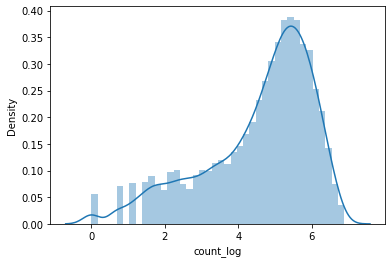

In [ ]:
import numpy as np

train['count_log'] = train['count'].apply(lambda x : np.log(x) if x > 0 else 0)

print('skewness(왜도): %f' %train['count_log'].skew())
print('kurtosis(첨도): %f' %train['count_log'].kurt())
sns.distplot(train['count_log'], label='skewness')

# 필요없는 count값 없애주기 
train.drop('count', axis=1, inplace=True)

## windspeed 0 대체값 찾기

In [ ]:
# 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다. 
from sklearn.ensemble import RandomForestRegressor

def predict_windspeed(data):

    # 풍속이 0인 것과 아닌 것을 나누어준다. 
    w_train = data[data['windspeed'] != 0]
    w_test = data[data['windspeed'] == 0]

    # 풍속을 예측할 피처를 선택한다. 
    feature = ['season', 'weather', 'temp', 'atemp', 'humidity']

    # 랜덤포레스트를 사용한다. 
    model = RandomForestRegressor()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.  
    model.fit(w_train[feature], w_train['windspeed'])

    # 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다. 
    predict = model.predict(w_test[feature])

    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다. 
    w_test['windspeed'] = predict

    # 두 데이터프레임을 합쳐준다. 
    data = w_train.append(w_test)

    # 풍속의 데이터타입을 float으로 지정해 준다. 
    data['windspeed'] = data['windspeed'].astype('float') 

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data 

In [ ]:
# 0값을 조정한다. 
train = predict_windspeed(train)
test = predict_windspeed(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## one-hot encoding 범주형 변수 처리

* season, workingday, weather 변수는 숫자로 된 값이 '수치'를 의미하지 않는다. 따라서 원핫인코딩으로 범주형 변수를 처리해준다. 

In [ ]:
# prefix란 변수 생성명 앞에 weather_1 이런 식으로 생성되게 하는 것 
train = pd.get_dummies(train, columns = ['weather', 'season', 'workingday'])
test = pd.get_dummies(test, columns = ['weather', 'season', 'workingday'])

In [ ]:
train.sample()

,datetime,holiday,temp,atemp,humidity,windspeed,casual,registered,year,month,...,weather_1,weather_2,weather_3,weather_4,season_1,season_2,season_3,season_4,workingday_0,workingday_1
8583,2012-10-11 17:00:00,0,20.5,24.24,39,19.0012,90,737,2012,10,...,1,0,0,0,0,0,0,1,0,1


In [ ]:
test.sample()

,datetime,holiday,temp,atemp,humidity,windspeed,year,month,day,hour,...,weather_1,weather_2,weather_3,weather_4,season_1,season_2,season_3,season_4,workingday_0,workingday_1
4768,2012-09-21 17:00:00,0,27.88,31.82,57,19.0012,2012,9,21,17,...,1,0,0,0,0,0,1,0,0,1


# Modeling 

## train에 사용될 변수를 선택하자 

In [ ]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [ ]:
# submission의 형태를 살펴보았을 때, datetime을 기준으로 예측값을 적었다. 
# 따라서 test의 datetime은 미래의 submission을 위해서 따로 저장해 두기로 한다. 
test_datetime = test['datetime']

In [ ]:
train.drop(['datetime','holiday','temp','registered','casual','day','minute','second'], axis=1, inplace=True)
test.drop(['datetime','holiday','temp','day','minute','second'], axis=1, inplace=True)

In [ ]:
test.columns

Index(['atemp', 'humidity', 'windspeed', 'year', 'month', 'hour', 'dayofweek',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'season_1',
       'season_2', 'season_3', 'season_4', 'workingday_0', 'workingday_1'],
      dtype='object')

## 데이터셋 분할 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [ ]:
# 데이터프레임 형태가 아니라 array 형태여야 하기 때문에 values를 취해준다.  
X_train = train.drop('count_log',axis=1).values
y_train = train['count_log'].values 
X_test = test.values 

# train : val = 0.8 : 0.2로 split 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2000)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape) 
print(y_val.shape)

(8708, 17)
(2178, 17)
(8708,)
(2178,)


## 모델링 및 학습 

In [ ]:
from sklearn.ensemble import RandomForestRegressor 

model = RandomForestRegressor(n_estimators=2000,
                              n_jobs=-1, 
                              random_state=0)

# model.fit(X,y)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

## 모델 성능 평가 

간단하게 accuracy를 출력해 보았다. 과적합이 발생하지 않도록 n_estimators 값을 조정해준다. 

In [ ]:
score_train = model.score(X_train, y_train)
score_val = model.score(X_val, y_val)

print('train score: %f'%score_train)
print('validation score: %f'%score_val)

train score: 0.992848
validation score: 0.946770


## 예측 및 submission.csv 생성 

In [ ]:
# 모델 예측 
predict = model.predict(X_test)

In [ ]:
# 새로운 데이터프레임을 생성하고, 거기에 test_datetime과 예측한 결과값인 predict를 넣어준다
submission = pd.DataFrame()
submission['datetime'] = test_datetime
submission['count_log'] = predict 

submission.head()

,datetime,count_log
0,2011-01-20 00:00:00,2.319213
1,2011-01-20 03:00:00,0.996751
2,2011-01-20 04:00:00,0.988925
3,2011-01-20 05:00:00,1.473645
4,2011-01-20 06:00:00,3.484985


In [ ]:
# 초반에 count에 log를 취해서 정규화 시켜준 것을 꼭 기억하자 
# 따라서 마지막으로 count_log에 다시 log를 취해 원래의 값을 찾아준다.
# 로그로 표현된 값에 np.exp를 씌워 원본 값을 찾아준다.  

submission['count'] = np.exp(submission['count_log'])
submission.drop('count_log', axis=1, inplace=True)
submission.head()

,datetime,count
0,2011-01-20 00:00:00,10.167668
1,2011-01-20 03:00:00,2.709464
2,2011-01-20 04:00:00,2.688344
3,2011-01-20 05:00:00,4.365117
4,2011-01-20 06:00:00,32.621927


In [ ]:
submission.to_csv('submission_rf.csv', index=False)

결과는 0.43925